In [9]:
%matplotlib inline
import numpy as np
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt

In [10]:
class LinReg(BaseEstimator):
    def __init__(self, gd_type='full', 
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-3, eta=1e-2,
                 beta_1=0.9 , beta_2=0.999 ,epsilon=1e-8):
        avail_gd_types=['full','stochastic','momentum','adam']
        if gd_type not in avail_gd_types:
            raise ValueError("gd_type not in {}".format(avail_gd_types))
            
        """
        gd_type: 'full'/'stochastic' /'momentum /adam'
        tolerance: stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (l) 
        eta: learning rate
        alpha: momentum coeff
        beta_1, beta_2: moment vectors
        epsilon: epsilon for Adam
        weight_history: add a history of weights
        loss_history: list of loss function values at each training iteration
        """
        
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.w0 = w0
        self.max_iter = max_iter
        self.alpha = alpha
        self.eta = eta
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.w = None       
        self.weight_history = np.zeros((max_iter,9))
        self.loss_history = np.zeros(max_iter) 
                
    def fit(self, X, y):
        const_column = np.ones(len(X))
        X = np.concatenate((const_column.reshape(-1, 1), X), axis=1)
        self.weight_history = np.empty((self.max_iter, X.shape[1]))
        if self.w0 is not None:
            self.w=self.w0
        else:
            self.w=np.ones(X.shape[1])
        for i in range(self.max_iter):
            self.loss_history[i] = self.calc_loss(X, y)
            if i > 0 and \
                self.loss_history[:-10].ptp() < self.tolerance:
                break
            gradient = self.calc_gradient(X,y)
            if self.gd_type == 'adam':
                if i == 0:
                    m = 0
                    v = 0
                    t = 0
                t += 1
                m = self.beta_1 * m + (1 - self.beta_1) * gradient
                v = self.beta_2 * v + (1 - self.beta_2) * gradient**2
                m_with_hat = m / (1 - self.beta_1**t)
                v_with_hat = v / (1 - self.beta_2**t)
                self.w = self.w - self.alpha * m_with_hat / (np.sqrt(v_with_hat) + self.epsilon)
            else:
                step = gradient*self.eta/(i+1)**0.51
                
                """
                step is reduced on each iteration
                conforming the Robbins-Monro requirement
                (https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586)
                """
                
                if self.gd_type=='momentum':
                    if i == 0:
                        self.inertia = np.zeros(X.shape[1])
                    else:
                        self.inertia = self.alpha*self.inertia+step
                        step=self.inertia
                self.w-=step
            self.weight_history[i]=self.w
        return self

    def predict(self, X):
        if self.w is None:
            raise Exception('Not_trained_yet')
        const_column = np.ones(len(X))
        X = np.concatenate((const_column.reshape(-1, 1), X), axis=1)
        return np.dot(X,self.w)
    
    def calc_gradient(self, X, y):
        if self.gd_type in ['full', 'momentum']:
            return self.loss_grad(X,y)   
        if self.gd_type in ['stochastic', 'adam']:
            i=np.random.randint(len(y))
            return self.loss_grad(X[i].reshape(1, X.shape[1]), 
                                  y[i].reshape(1))
    def loss_grad(self,X,y):
        return 2/len(y)*np.dot(np.dot(X,self.w)-y,X)
    
    def R2(self,X,y):
        return 1-((np.dot(X,self.w)-y)**2).sum()/(y.mean()-y).sum()
    
    def calc_loss(self, X, y):
        return ((np.dot(X,self.w)-y)**2).sum()/len(y)

In [11]:
X = np.random.rand(100, 2)
y = np.dot(np.sin(X), (1, 2))+ (np.random.rand(100) - 0.5) * 2

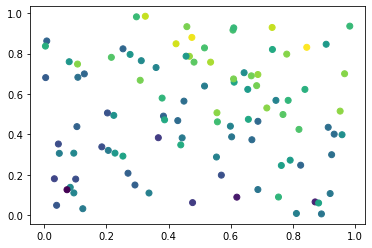

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [13]:
r_full = LinReg(gd_type='full', max_iter=10000)
r_stoc = LinReg(gd_type='stochastic', max_iter=10000)
r_mome = LinReg(gd_type='momentum', alpha=0.5, max_iter=10000)
r_adam = LinReg(gd_type='adam', alpha=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, max_iter=10000)

In [14]:
r_full.fit(X, y)
r_stoc.fit(X, y)
r_mome.fit(X, y)
r_adam.fit(X, y)

LinReg(gd_type='adam', max_iter=10000)

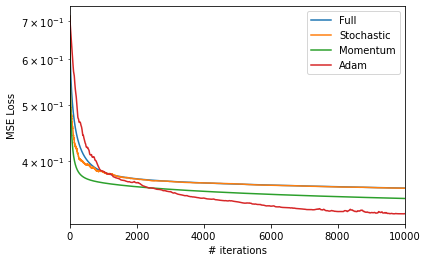

In [15]:
plt.plot(r_full.loss_history, label='Full')
plt.plot(r_stoc.loss_history, label='Stochastic')
plt.plot(r_mome.loss_history, label='Momentum')
plt.plot(r_adam.loss_history, label='Adam')
plt.legend()
plt.xlabel('# iterations')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.xlim(0, 10000)
plt.show()